In [1]:
from pudipflow import PUDIPFlow
import numpy as np
import h5py
import matplotlib.pyplot as plt


In [2]:
data_path = './TestData.h5'

with h5py.File(data_path, 'r') as f:
    img_gt = f['img'][:]
    segmask = f['segmask'][:]

Nv, Nt, SPE, PE, FE = img_gt.shape
SPE, PE, FE = segmask.shape

img_gt = np.transpose(img_gt, (0,1,4,3,2))
segmask = np.transpose(segmask, (2, 1, 0))
VENC  = 150
print(img_gt.shape, segmask.shape)

(4, 20, 88, 96, 19) (88, 96, 19)


In [3]:
def complex2magflow(img):
    mag = np.mean(np.abs(img), axis=0)
    flow = np.angle(img[1:]*np.conj(img[0:1]))
    return mag, flow

def wrapflow(flow, fold):
    return np.angle(np.exp(1j*flow*fold))

def magflow(flow):
    return np.sqrt(np.sum(flow**2, axis=0))

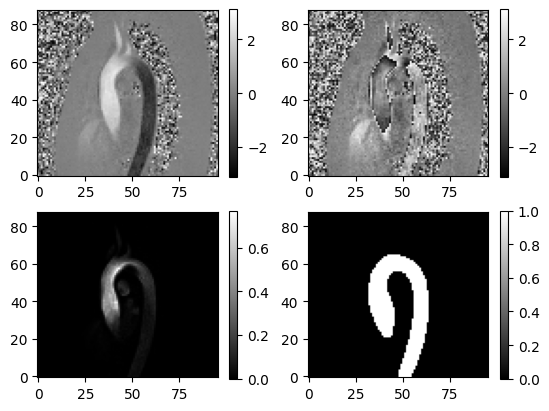

In [4]:
fold = 3 # 150 -> 50

Nv, Nt, FE, PE, SPE = img_gt.shape

mag_gt, flow_gt = complex2magflow(img_gt)
flow_wrapped = wrapflow(flow_gt, fold=fold)

alpha = 1
pcmra = mag_gt * magflow(flow_gt)
weightmask = np.std(pcmra, axis=0)**alpha * pcmra
weightmask = weightmask[None]
showt = 3
showv = 0
showz = SPE // 2 + 2
plt.subplot(221)
plt.imshow(flow_gt[showv,showt, :, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.subplot(222)
plt.imshow(flow_wrapped[showv,showt, :, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.subplot(223)
plt.imshow(weightmask[0,3, :, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.subplot(224)
plt.imshow(segmask[:, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.show()

In [5]:
unwrapper = PUDIPFlow(
    venc=VENC / fold,
    level=4,
    features=64,
    input_depth=64,
    lr=1e-3,
    num_iter=1000,
    temporal_tv=1.0,
    loss_type='l1',
    device="cuda:0",
)



/home/ryy/miniconda3/envs/ryy/lib/python3.9/site-packages/pudipflow/core.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ryy/miniconda3/envs/ryy/lib/python3.9/site-packages/pudipflow/core.py:496: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1000 | Loss 1.03e+04 | NRMSE 0.0378: 100%|██████████| 1000/1000 [01:10<00:00, 14.27it/s]


[PUDIPFlow] Saved training video to: ./pudipflow_training.mp4
[PUDIPFlow] Best NRMSE: 0.0277 @ epoch 112


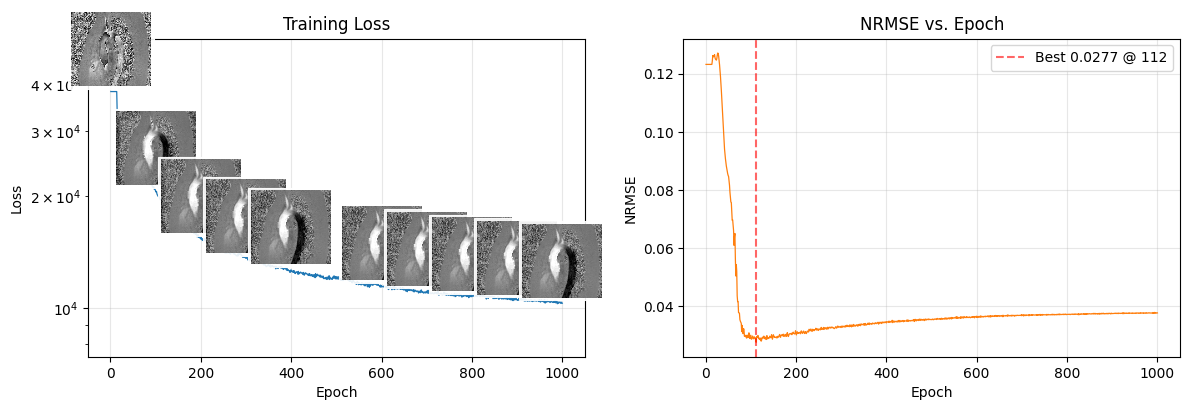

In [6]:
result, history = unwrapper.run(
    wrapped_data=flow_wrapped[showv:showv+1], 
    weightmask=weightmask,
    gt=flow_gt[showv:showv+1] / np.pi * 150,     
    segmask=segmask,   
    plot=True,
    snapshot_every=100,
    max_snapshots=10,
    snapshot_cmap="gray",
    plot_figsize=12,
    showv=showv,
    showt=showt,
    showz=showz,
    video_every=10, 
    save_video=True,
    video_path="./pudipflow_training.mp4",
    video_fps=12,
    video_dpi=120,
    video_cmap="gray",
)